In [1]:
import pandas as pd

# Load DataFrame from Pickle
df_all_shuffled_training_mass = pd.read_pickle("df_all_shuffled_training_mass.pkl") # training sample

df_all_shuffled_noproton_mass = pd.read_pickle("df_all_shuffled_noproton_mass.pkl") 

df_all_shuffled_mass = pd.read_pickle("df_all_shuffled_mass.pkl") 

df_jpsiprotons_mass_gen3 = pd.read_pickle("df_jpsiprotons_mass_gen3.pkl") 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# #------------------------------------------
# # 1. Load and Prepare the Data
# #------------------------------------------

X=df_all_shuffled_training_mass[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
# # Extract mass separately
# mass = df['mass'].values
mass=df_all_shuffled_training_mass['InvariantMass'].values
# # Create a train/test split
X_train, X_test, mass_train, mass_test = train_test_split(X, mass, test_size=0.05, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform training data, transform test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



2025-10-26 22:18:09.714258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(X_train.shape, X_test.shape)

print(X_train.shape[0])


(171000, 6) (9000, 6)
171000


In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
# tf.debugging.set_log_device_placement(True)


TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU (if any)


In [6]:
# #------------------------------------------
# # 2. Define the Autoencoder Model
# #------------------------------------------

input_dim = X_train.shape[1]  # should be 6
encoding_dim = 4              # latent space dimension

# # Input layer
input_layer = Input(shape=(input_dim,))

# # Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# # Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # best, 185 epochs automatic stop

#------------------------------------------
# 3. Train the Autoencoder
#------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,
    restore_best_weights=True
)

history = autoencoder.fit(X_train, X_train, 
                          epochs=500,
                          # epochs=500,
                          batch_size=256,
                        #   batch_size=64,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=2,
                          callbacks=[early_stopping]
                         )

# with tf.device('/CPU:0'):
#     history = autoencoder.fit(X_train, X_train,
#                               epochs=500,
#                               batch_size=64,
#                               validation_data=(X_test, X_test),
#                               callbacks=[early_stopping],
#                               verbose=2)
#     print(f"Training stopped at epoch {len(history.history['loss'])}")

print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
668/668 - 3s - 4ms/step - loss: 0.0244 - val_loss: 0.0084
Epoch 2/500
668/668 - 2s - 3ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 3/500
668/668 - 2s - 3ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 4/500
668/668 - 1s - 2ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 5/500
668/668 - 1s - 2ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/500
668/668 - 1s - 2ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 7/500
668/668 - 1s - 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/500
668/668 - 1s - 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/500
668/668 - 1s - 2ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/500
668/668 - 1s - 2ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 11/500
668/668 - 1s - 2ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 12/500
668/668 - 1s - 2ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 13/500
668/668 - 1s - 2ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 14/500
668/668 - 1s - 2ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 15/500
66

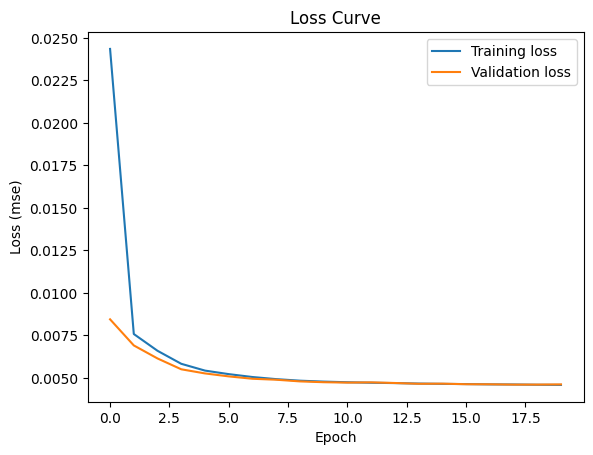

In [7]:
# Optional: Plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.title('Loss Curve')
plt.savefig("final_loss.pdf")
plt.legend()
plt.show()


In [8]:
# #------------------------------------------
# # 4. Use the Autoencoder for Anomaly Detection
# #------------------------------------------

# # Compute reconstruction on the test set
X_test_pred = autoencoder.predict(X_test)

# # Calculate MSE per sample
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
#plot

# You need to define a threshold for what you consider "anomalous"
# This could be determined by analyzing the MSE distribution on training data, for example.
threshold = 1 #np.mean(mse) + 3*np.std(mse)  # Example heuristic

# Find anomalous events
anomalous_indices = np.where(mse > threshold)[0]

#------------------------------------------
# 5. Retrieve the Mass for Anomalous Events
#------------------------------------------

# For any anomalous event, we can now look up its mass
if len(anomalous_indices) > 0:
    print("Anomalous Event Indices:", anomalous_indices)
    print("Mass values for anomalous events:", mass_test[anomalous_indices])
else:
    print("No anomalies detected under this threshold.")


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
No anomalies detected under this threshold.


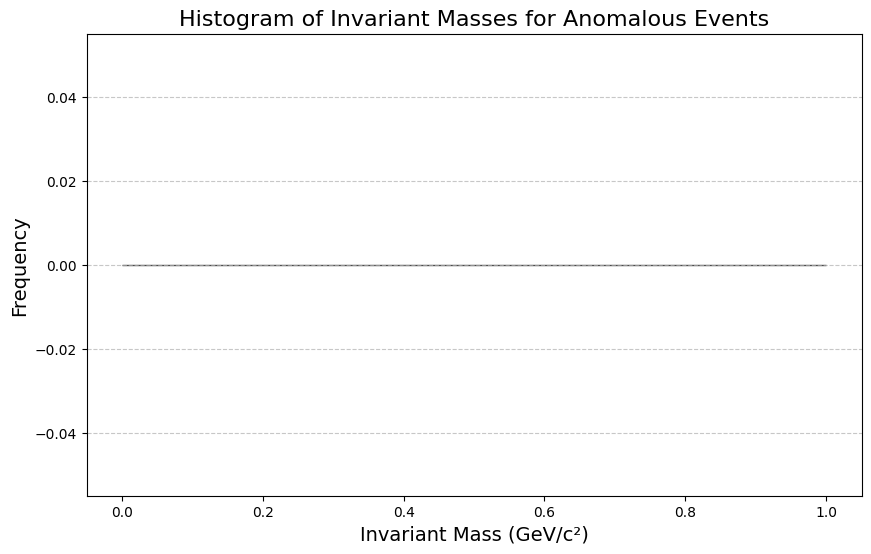

In [9]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(mass_test[anomalous_indices], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Invariant Masses for Anomalous Events', fontsize=16)
plt.xlabel('Invariant Mass (GeV/c²)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()

In [10]:

mse_threshold = 0.01
mass_cutoff = 0
#-------Tryiing to filter for events >1GeV

df_mass_cut_noexotica = df_all_shuffled_noproton_mass[df_all_shuffled_noproton_mass['InvariantMass'] > mass_cutoff]
X_noexotica = df_mass_cut_noexotica[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
X_noexotica = scaler.transform(X_noexotica)

X_pred_noexotica = autoencoder.predict(X_noexotica)
mse_noexotica = np.mean(np.power(X_noexotica - X_pred_noexotica, 2), axis=1)

df_high_mse_noexotica = df_mass_cut_noexotica[mse_noexotica > mse_threshold]
alice_noexotica_masses = df_high_mse_noexotica['InvariantMass'].values

#NO EXOTICA
df_mass_cut_exotica = df_all_shuffled_mass[df_all_shuffled_mass['InvariantMass'] > mass_cutoff]
X_exotica = df_mass_cut_exotica[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
X_exotica = scaler.transform(X_exotica)

X_pred_exotica = autoencoder.predict(X_exotica)
mse_exotica = np.mean(np.power(X_exotica - X_pred_exotica, 2), axis=1)

df_high_mse_exotica = df_mass_cut_exotica[mse_exotica > mse_threshold]
alice_exotica_masses = df_high_mse_exotica['InvariantMass'].values




72103/72103 ━━━━━━━━━━━━━━━━━━━━ 176s 2ms/step
72179/72179 ━━━━━━━━━━━━━━━━━━━━ 169s 2ms/step


In [11]:
# df_jpsipro = df_jpsiprotons_mass_gen3[df_jpsiprotons_mass_gen3['InvariantMass'] > mass_cutoff]
# X_jpsipro = df_jpsipro[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
# X_jpsipro = scaler.transform(df_jpsipro)

# X_pred_jpsipro = autoencoder.predict(df_jpsipro)
# mse_jpsipro = np.mean(np.power(df_jpsipro - X_pred_jpsipro, 2), axis=1)

# df_high_mse_jpsipro = df_jpsipro[mse_jpsipro > mse_threshold]
# jpsipro_masses = df_high_mse_jpsipro['InvariantMass'].values


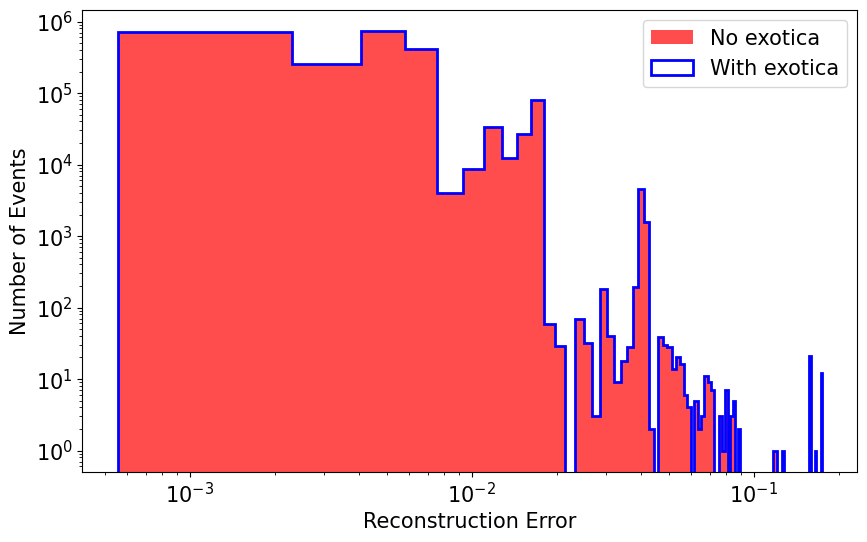

In [12]:
#combined = np.concatenate([mse_alice_noexotica, mse_alice_exotica])
combined = np.concatenate([mse_noexotica, mse_exotica])

n_bins = 100

bin_edges = np.linspace(combined.min(), combined.max(), n_bins + 1)

plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 15})

plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
#plt.hist(mse_alice_noexotica, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
#plt.hist(mse_alice_exotica, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

plt.hist(mse_noexotica, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
plt.hist(mse_exotica, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
#plt.title('Reconstruction Error Distribution for ALICE cocktail, w/ and w/o exotica')
plt.legend()

plt.savefig("final_error_proton.pdf")
# Show the plot
plt.show()

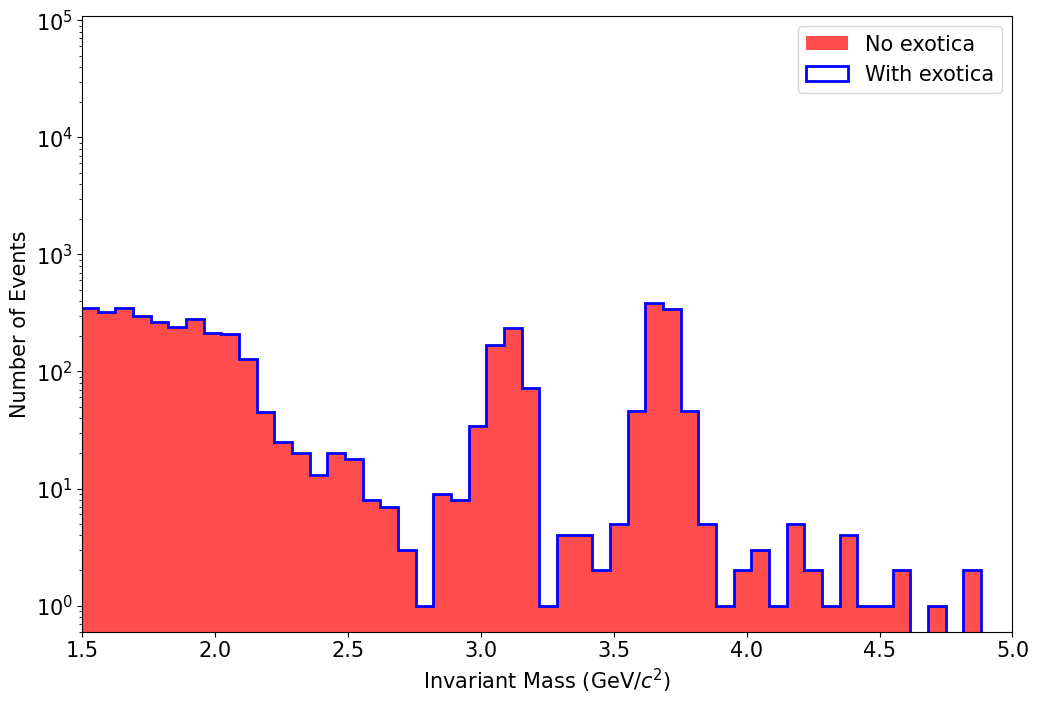

In [13]:
mse_threshold = 0.1
# Filter cocktail no exotica with reconstruction error above the threshold
# alice_noexotica_high_mse = df_all_shuffled_nopq_mass[mse_alice_noexotica > mse_threshold]
# alice_noexotica_masses = alice_noexotica_high_mse['InvariantMass'].values

# # Filter cocktail with exotica with reconstruction error above the threshold
# alice_exotica_high_mse = df_all_shuffled_mass[mse_alice_exotica > mse_threshold]
# alice_exotica_masses = alice_exotica_high_mse['InvariantMass'].values

# #-------Tryiing to filter for events >1GeV

# df_mass_cut_noexotica = df_all_shuffled_nopq_mass[df_all_shuffled_nopq_mass['InvariantMass'] > 1.0]
# X_noexotica = df_mass_cut_noexotica[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
# X_noexotica = scaler.transform(X_noexotica)

# X_pred_noexotica = autoencoder.predict(X_noexotica)
# mse_noexotica = np.mean(np.power(X_noexotica - X_pred_noexotica, 2), axis=1)

# df_high_mse_noexotica = df_mass_cut_noexotica[mse_noexotica > mse_threshold]
# alice_noexotica_masses = df_high_mse_noexotica['InvariantMass'].values

# #NO EXOTICA
# df_mass_cut_exotica = df_all_shuffled_mass[df_all_shuffled_mass['InvariantMass'] > 1.0]
# X_exotica = df_mass_cut_exotica[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
# X_exotica = scaler.transform(X_exotica)

# X_pred_exotica = autoencoder.predict(X_exotica)
# mse_exotica = np.mean(np.power(X_exotica - X_pred_exotica, 2), axis=1)

# df_high_mse_exotica = df_mass_cut_exotica[mse_exotica > mse_threshold]
# alice_exotica_masses = df_high_mse_exotica['InvariantMass'].values

combined_masses = np.concatenate([alice_noexotica_masses, alice_exotica_masses])

n_bins = 100

bin_edges = np.linspace(combined_masses.min(), combined_masses.max(), n_bins + 1)

# Plot the invariant mass distribution
plt.figure(figsize=(12, 8))

plt.hist(alice_noexotica_masses, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
plt.hist(alice_exotica_masses, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

# Add labels and title
plt.xlabel(r'Invariant Mass (GeV/$c^2$)')
plt.ylabel('Number of Events')
plt.yscale('log')
plt.xlim(1.5, 5)
plt.ylim(0.6,110000)
#plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold}')
plt.legend()

plt.savefig("final_mass_proton.pdf")
# Show the plot
plt.show()


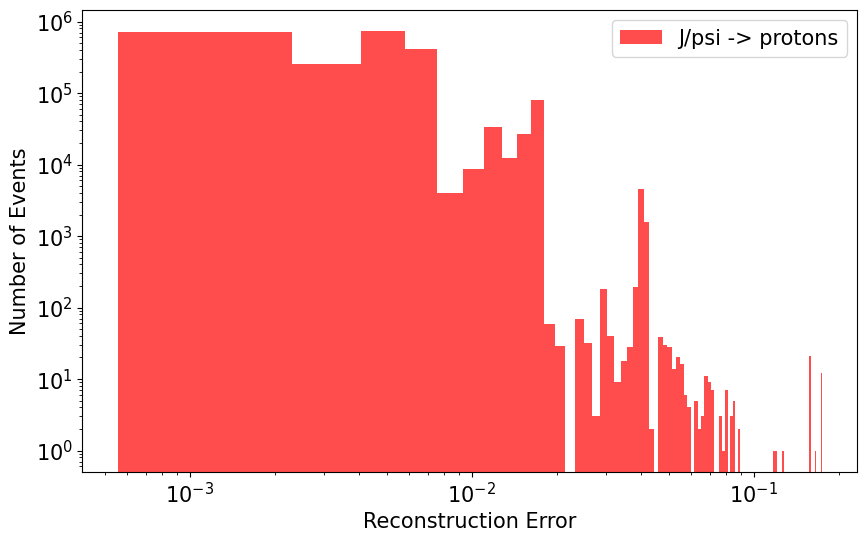

In [14]:
#combined = np.concatenate([mse_alice_noexotica, mse_alice_exotica])
combined = np.concatenate([mse_noexotica, mse_exotica])

n_bins = 100

bin_edges = np.linspace(combined.min(), combined.max(), n_bins + 1)

plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 15})

plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
#plt.hist(mse_alice_noexotica, bins=bin_edges, alpha=0.7, label='No exotica', color='red')
#plt.hist(mse_alice_exotica, bins=bin_edges, histtype='step', color='blue', linewidth=2, label='With exotica')

plt.hist(mse_noexotica, bins=100, alpha=0.7, label='J/psi -> protons', color='red')

# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
#plt.title('Reconstruction Error Distribution for ALICE cocktail, w/ and w/o exotica')
plt.legend()

plt.savefig("final_error_proton.pdf")
# Show the plot
plt.show()